In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def load_data(image_size, labels, base_path):
    X = []
    Y = []
    for label in labels:
        folderPath = os.path.join(base_path, label)
        for img_name in os.listdir(folderPath):
            img_path = os.path.join(folderPath, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            Y.append(labels.index(label))
    return X, Y

In [ ]:
image_size = 224
BATCH_SIZE = 32
NUM_CLASSES = 2
labels = ['covid', 'pneumonia']
base_path = '/content/drive/MyDrive/covid_pneumonia/'

# Load data
X, Y = load_data(image_size, labels, base_path)

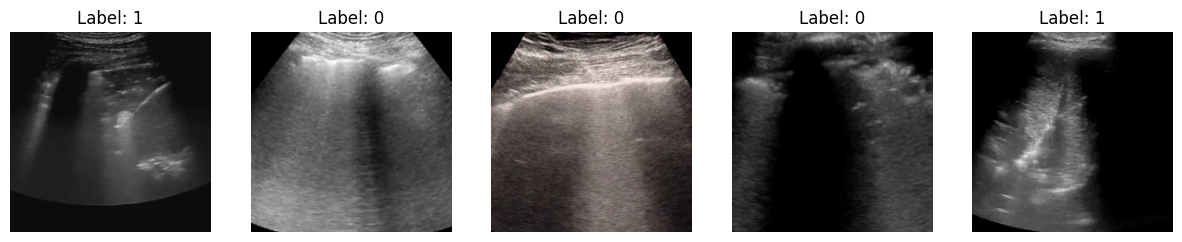

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to display random 5 images with labels
def show_random_images(X, Y, num_images=5):
    indices = random.sample(range(len(X)), num_images)  # Select random indices
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Create subplots

    for i, idx in enumerate(indices):
        axes[i].imshow(X[idx])  # Show image
        axes[i].set_title(f"Label: {Y[idx]}")  # Set label as title
        axes[i].axis("off")  # Hide axes

    plt.show()

# Call the function
show_random_images(X, Y)


In [ ]:
# X = np.array(X)
# Y = np.array(Y)

# Step 1: Split into train + validation_temp and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Step 2: Split validation_temp into validation and test
# X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [1]:
def freeze_layers_with_exclusion(model, excluded_layers):
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the layers in the excluded list
    for name, param in model.named_parameters():
        if any(layer in name for layer in excluded_layers):
            param.requires_grad = True


def print_layers_req_grad(model):
    # Print all layers and their requires_grad status
    for name, param in model.named_parameters():
        print(f'Parameter: {name}, Requires Gradient: {param.requires_grad}')

In [3]:
import timm
import torch.nn as nn

# Define model parameters
pretrained = True  # Use pretrained weights
num_classes = 2   # Change this based on dataset

# Load the Swin Transformer model
print(f"\nUsing pretrained weights: {pretrained}\n")
model = timm.create_model('swin_base_patch4_window7_224.ms_in1k',
                          pretrained=pretrained,
                          num_classes=0)

# Freeze layers except classification head
if pretrained:
    excluded_layers = ['head']  # Keep only the classification head trainable
    freeze_layers_with_exclusion(model, excluded_layers)

# Get the number of input features for the classifier
num_features = model.num_features  # or model.get_classifier().in_features

# Define a new classification head
num_classes = 2  # Change based on your dataset
new_head = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

# Assign the new classification head
model.head = new_head  # For models like EfficientNet
# model.fc = new_head  # For models like ResNet (if applicable)

# Print model structure
print(model)



Using pretrained weights: True



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()  # Since it's a classification task
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decays LR every 5 epochs


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import Dataset, DataLoader
from PIL import Image


# Define a Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # Assuming images are numpy arrays or PIL images
        self.labels = labels  # Assuming labels are integers
        self.transform = transform  # Apply transforms if given

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, label

# Define transformations (Resize, Normalize, etc.)
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create Dataset & Dataloaders
train_dataset = CustomDataset(X_train, Y_train, transform=transform)
test_dataset = CustomDataset(X_test, Y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
images, labels = next(iter(train_loader))
print("Image shape:", images.shape)   # Should be (batch_size, 3, H, W)
print("Label shape:", labels.shape)   # Should be (batch_size,)

# Ensure labels are integer class indices
print("Label dtype:", labels.dtype)   # Should be torch.int64 (long)
print("Unique labels:", labels.unique())  # Should contain class indices like [0,1,2,...]


Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])
Label dtype: torch.int64
Unique labels: tensor([0, 1])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move model to GPU (if available)

import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

num_epochs = 10  # Set the number of epochs
all_preds, all_labels = [], []  # Store predictions for all epochs

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero out gradients
        # Extract feature maps
        features = model.forward_features(images)  # Shape: (batch_size, 7, 7, num_features)

        # Apply Adaptive Pooling to flatten spatial dimensions
        features = F.adaptive_avg_pool2d(features.permute(0, 3, 1, 2), (1, 1))  # (batch_size, num_features, 1, 1)
        features = features.view(features.shape[0], -1)  # Flatten to (batch_size, num_features)

        outputs = model.head(features)  # Pass through classifier
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Convert predictions to class labels
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

    train_acc = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%, F1 Score: {f1:.4f}")

    scheduler.step()  # Adjust learning rate

print("Training complete!")


Epoch 1/10, Loss: 0.0750, Accuracy: 98.99%, F1 Score: 0.9898
Epoch 2/10, Loss: 0.0722, Accuracy: 98.99%, F1 Score: 0.9898
Epoch 3/10, Loss: 0.0715, Accuracy: 98.61%, F1 Score: 0.9886
Epoch 4/10, Loss: 0.0677, Accuracy: 98.99%, F1 Score: 0.9889
Epoch 5/10, Loss: 0.0684, Accuracy: 98.86%, F1 Score: 0.9888
Epoch 6/10, Loss: 0.0629, Accuracy: 99.11%, F1 Score: 0.9892
Epoch 7/10, Loss: 0.0629, Accuracy: 99.24%, F1 Score: 0.9896
Epoch 8/10, Loss: 0.0633, Accuracy: 99.37%, F1 Score: 0.9901
Epoch 9/10, Loss: 0.0663, Accuracy: 98.73%, F1 Score: 0.9898
Epoch 10/10, Loss: 0.0620, Accuracy: 99.11%, F1 Score: 0.9900
Training complete!


In [ ]:
model.eval()  # Set to evaluation mode
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        # Extract feature maps
        features = model.forward_features(images)  # Shape: (batch_size, 7, 7, num_features)

        # Apply Adaptive Pooling to flatten spatial dimensions
        features = F.adaptive_avg_pool2d(features.permute(0, 3, 1, 2), (1, 1))  # (batch_size, num_features, 1, 1)
        features = features.view(features.shape[0], -1)  # Flatten to (batch_size, num_features)

        outputs = model.head(features)  # Pass through classifier
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 98.99%


In [ ]:
torch.save(model.state_dict(), "swinv2_finetuned.pth")


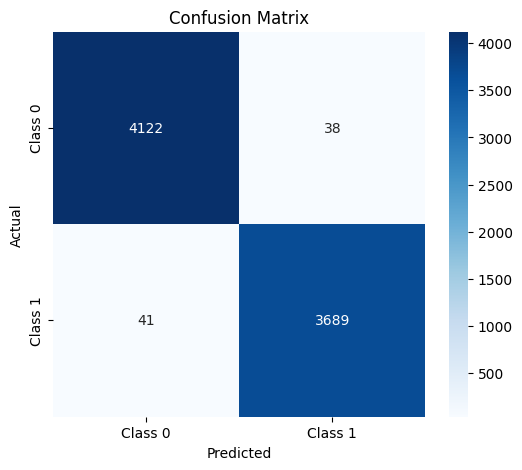

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ["Class 0", "Class 1"]  # Change if you have different classes

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()